In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap

In [3]:
from sklearn.manifold import TSNE

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext

import time 
from time import sleep

sc = SparkContext()
sc

<SparkContext master=yarn appName=pyspark-shell>

In [4]:
spark = SparkSession \
 .builder \
 .appName("Python Spark SQL basic example") \
 .config("spark.some.config.option", "some-value") \
 .getOrCreate()

In [5]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType,ArrayType

In [6]:
result = spark.read.parquet('s3://hids511final/corid_embedding_pca_200.parquet')

In [54]:
sample_seed_1 =  spark.read.parquet("s3://hids511final/corid_embedding_pca_200_sample_seed_01_1.parquet")

In [7]:
#sample_seed_1 = result[['_c0','EMBEDDING','pca_features']].sample(.01,1)

In [8]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [9]:
k_range = [2,20,35,50,75,100,150]
silhouette_scores = []
for k in tqdm(k_range):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(result.withColumnRenamed("pca_features","features"))
    predictions = model.transform(result.withColumnRenamed("pca_features","features"))

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance = " + str(silhouette))
    silhouette_scores.append(silhouette)


    

NameError: name 'k' is not defined

In [ ]:
kmeans = KMeans().setK(50).setSeed(1)
model = kmeans.fit(result.withColumnRenamed("pca_features","features"))
predictions = model.transform(result.withColumnRenamed("pca_features","features"))

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))
silhouette_scores.append(silhouette)


In [12]:
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.08471156184840854


In [35]:
trunc_pred = predictions[['_c0','EMBEDDING','prediction']].withColumnRenamed("_c0","_c0_pred")

In [36]:
trunc_pred.show()

+--------+--------------------+----------+
|_c0_pred|           EMBEDDING|prediction|
+--------+--------------------+----------+
|p2a87gq8|[-4.4241442680358...|        46|
|0ubbqima|[-2.2188601493835...|        17|
|yduqlwn0|[-3.8291807174682...|        23|
|xltd5eg4|[1.41468095779418...|         5|
|isnx6kh4|[2.76754713058471...|        20|
|oc9ksvzu|[-2.4803848266601...|        16|
|1iwqgbzs|[-1.8861353397369...|        18|
|d464w62z|[1.88679099082946...|        48|
|jjdvihkn|[-5.1217756271362...|        23|
|f1iklvp2|[-3.5954389572143...|        17|
|9mkmpwo4|[-3.0146420001983...|        22|
|6cdy3wmq|[-0.1483068466186...|        24|
|dbl3hnjq|[-2.5145726203918...|         4|
|07mf83wv|[-2.0421140193939...|        19|
|wmfojozm|[-3.7229957580566...|        39|
|uqrzzh0e|[-1.3794070482254...|        28|
|shccxcvp|[-1.6849477291107...|        33|
|o30wbq6m|[-2.5563042163848...|        42|
|gru7psp3|[-5.5762367248535...|        25|
|nsghcslj|[-0.5410556197166...|        49|
+--------+-

In [55]:
sample_seed_1_cluser_assinged = sample_seed_1.join(trunc_pred[['_c0_pred','prediction']],
                                                   sample_seed_1["_c0"] == trunc_pred["_c0_pred"],"left")

In [56]:
sample_seed_1_cluser_assinged.show()

+--------+--------------------+--------------------+--------+----------+
|     _c0|           EMBEDDING|        pca_features|_c0_pred|prediction|
+--------+--------------------+--------------------+--------+----------+
|1qswwxw8|[-5.6927232742309...|[15.6444404052320...|1qswwxw8|        15|
|5vvl0npo|[-2.3355121612548...|[47.8782494955001...|5vvl0npo|        28|
|5wraup2d|[1.34078013896942...|[-0.0133305518779...|5wraup2d|        32|
|5wraup2d|[1.34078013896942...|[-0.0133305518779...|5wraup2d|        32|
|76fftal3|[-3.1268446445465...|[41.1048164608631...|76fftal3|        27|
|7zo4o617|[-1.1468764543533...|[39.6879685406620...|7zo4o617|        40|
|85lg00a8|[1.17229330539703...|[-15.468575662867...|85lg00a8|         6|
|86w7qwbz|[0.36785805225372...|[-29.887670905835...|86w7qwbz|         1|
|86w7qwbz|[0.36785805225372...|[-29.887670905835...|86w7qwbz|         1|
|9fp80ujt|[2.01924157142639...|[-25.687166430257...|9fp80ujt|        10|
|9fp80ujt|[2.01924157142639...|[-25.687166430257...

In [57]:
df = pd.DataFrame(sample_seed_1_cluser_assinged[['_c0','EMBEDDING','prediction']].collect())

In [58]:
X = [np.array(i) for i in df[1].values]

In [59]:
X = np.array(X)

In [60]:
X_embedded = TSNE(n_components=2).fit_transform(X)

In [61]:
X_embedded.shape

(7014, 2)

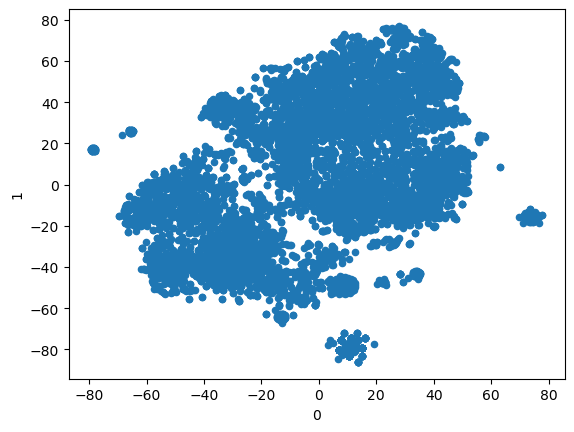

In [62]:
pd.DataFrame(X_embedded).plot.scatter(x=0,y=1)
plt.show()
plt.close()

In [64]:
TSNE_2d = pd.DataFrame(X_embedded)

In [68]:
TSNE_2d['cluster']= df[2].values

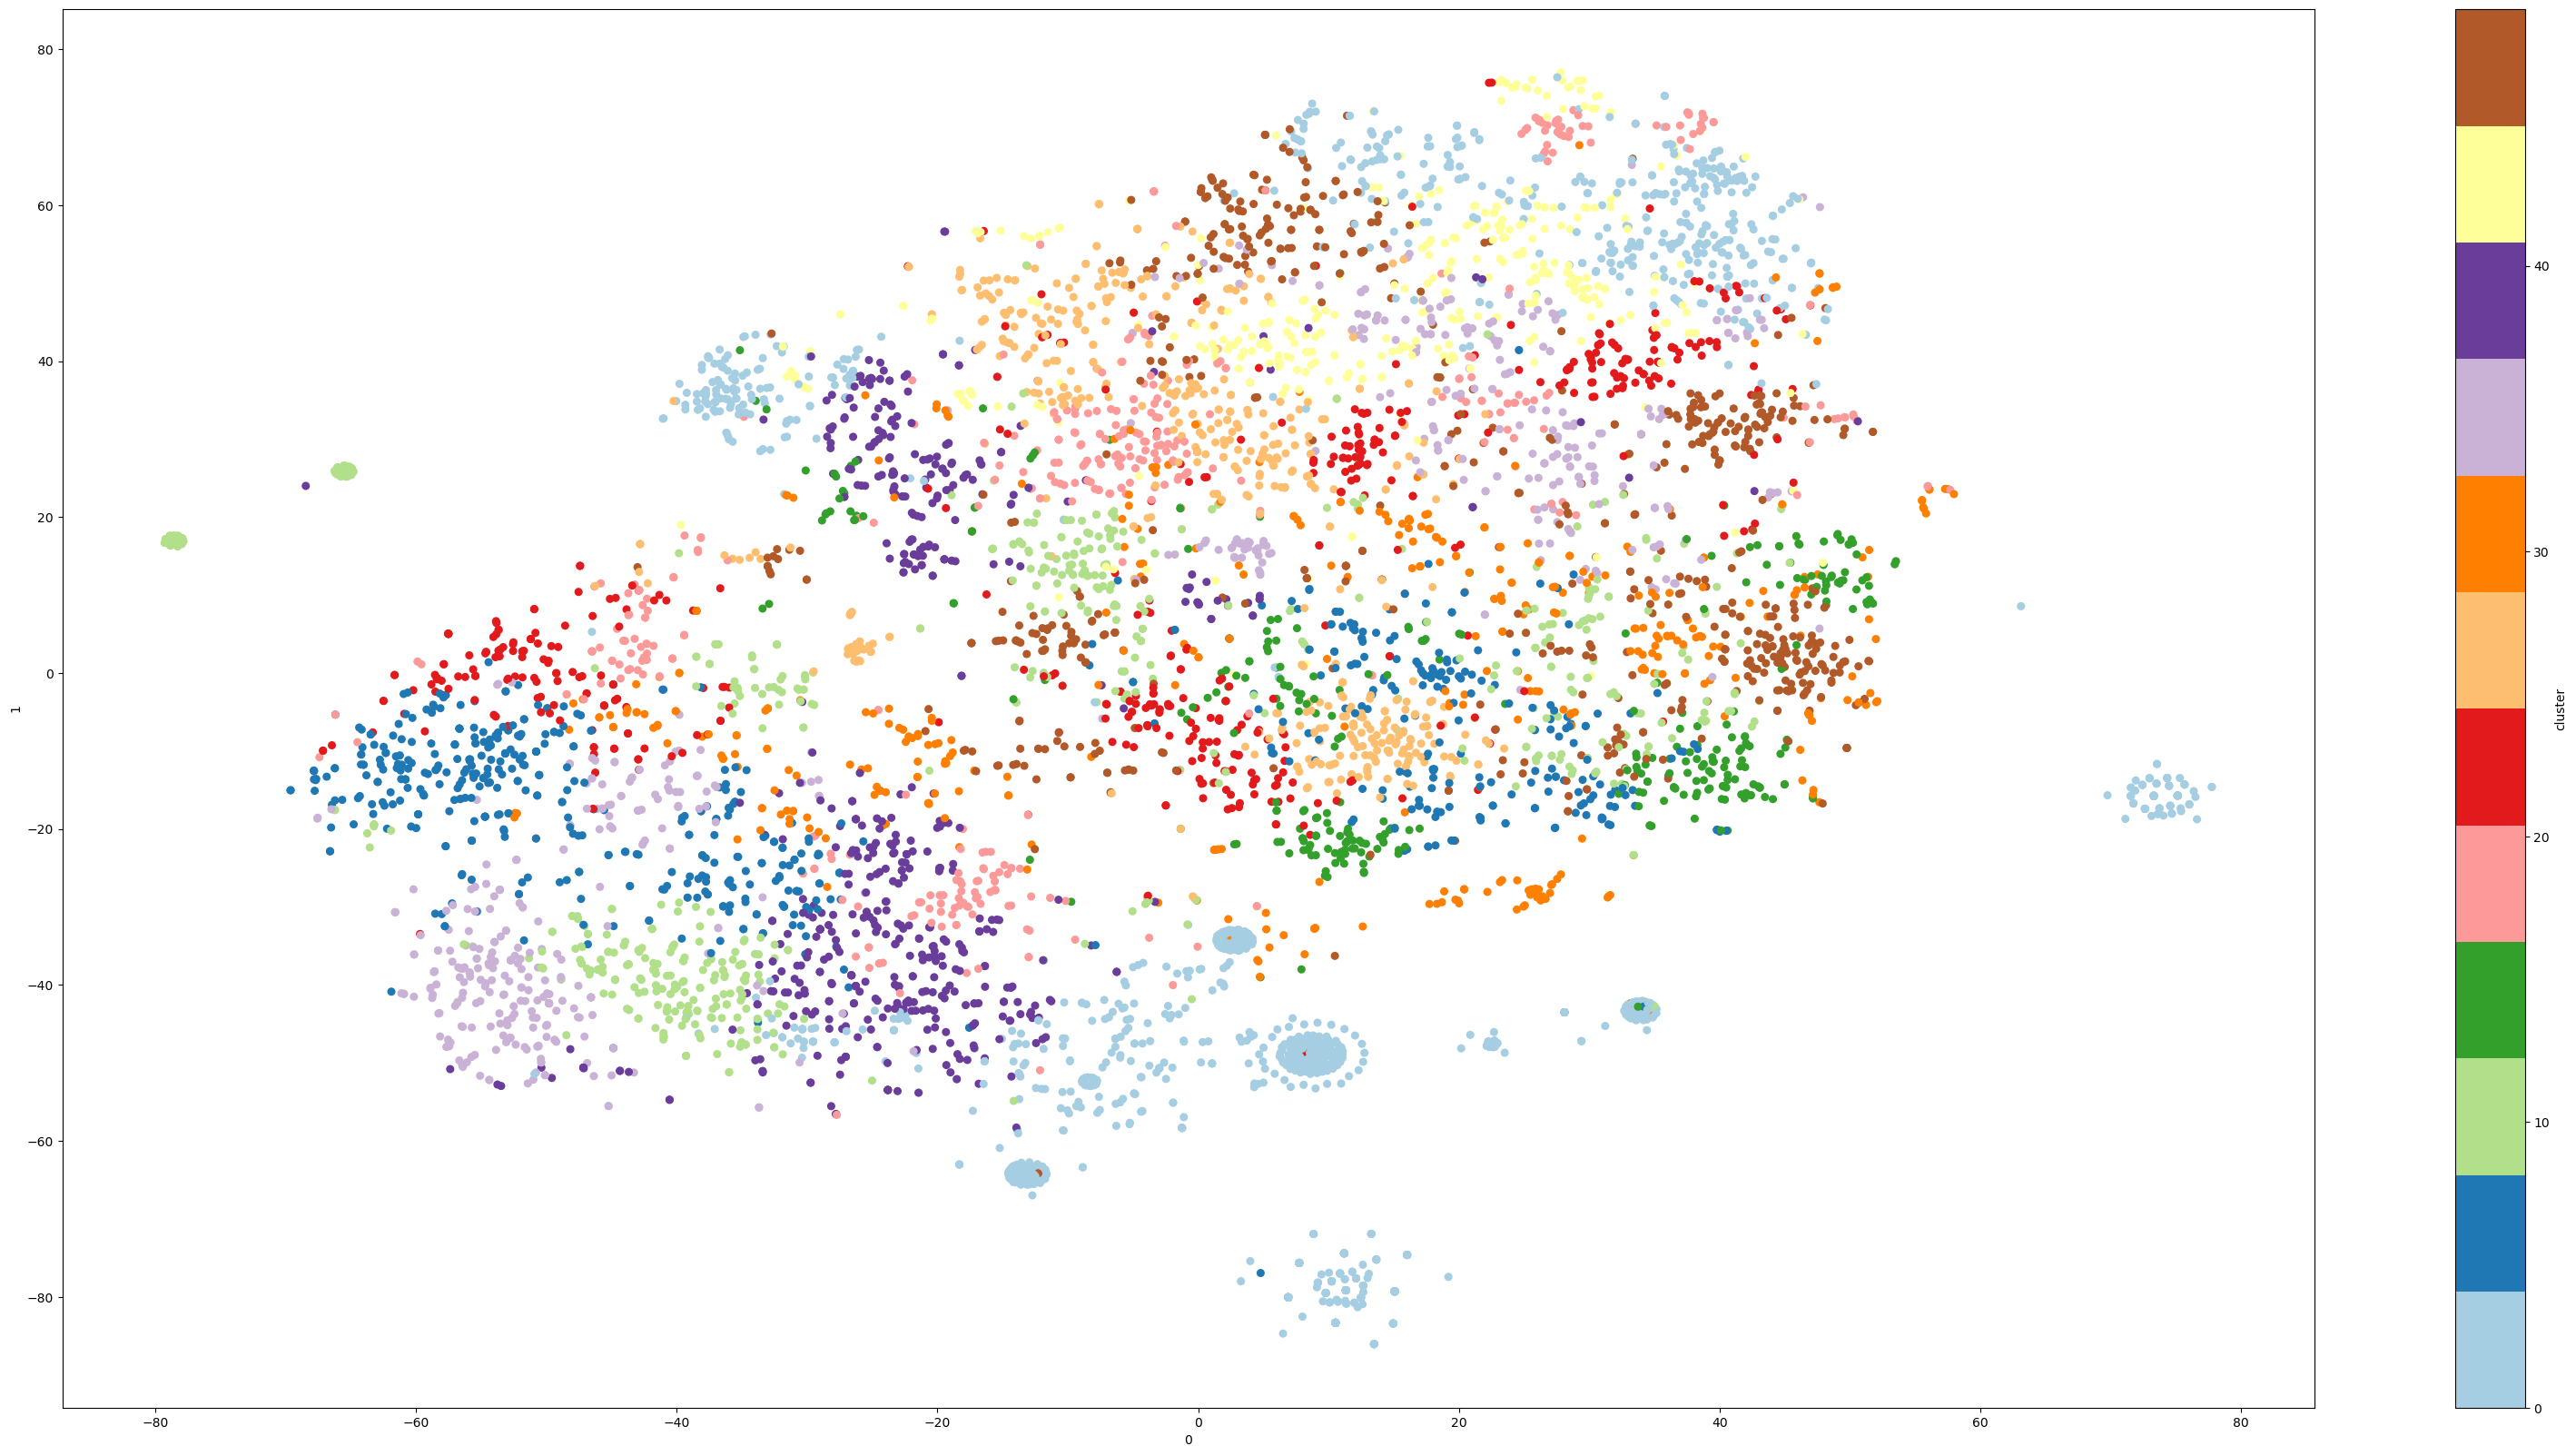

In [82]:
c_map_opt = ['Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']

#for cmap in c_map_opt:

pd.DataFrame(TSNE_2d).plot.scatter(x=0,y=1,c='cluster', cmap='Paired', s=30,figsize=(40,20))
plt.show()
plt.close()

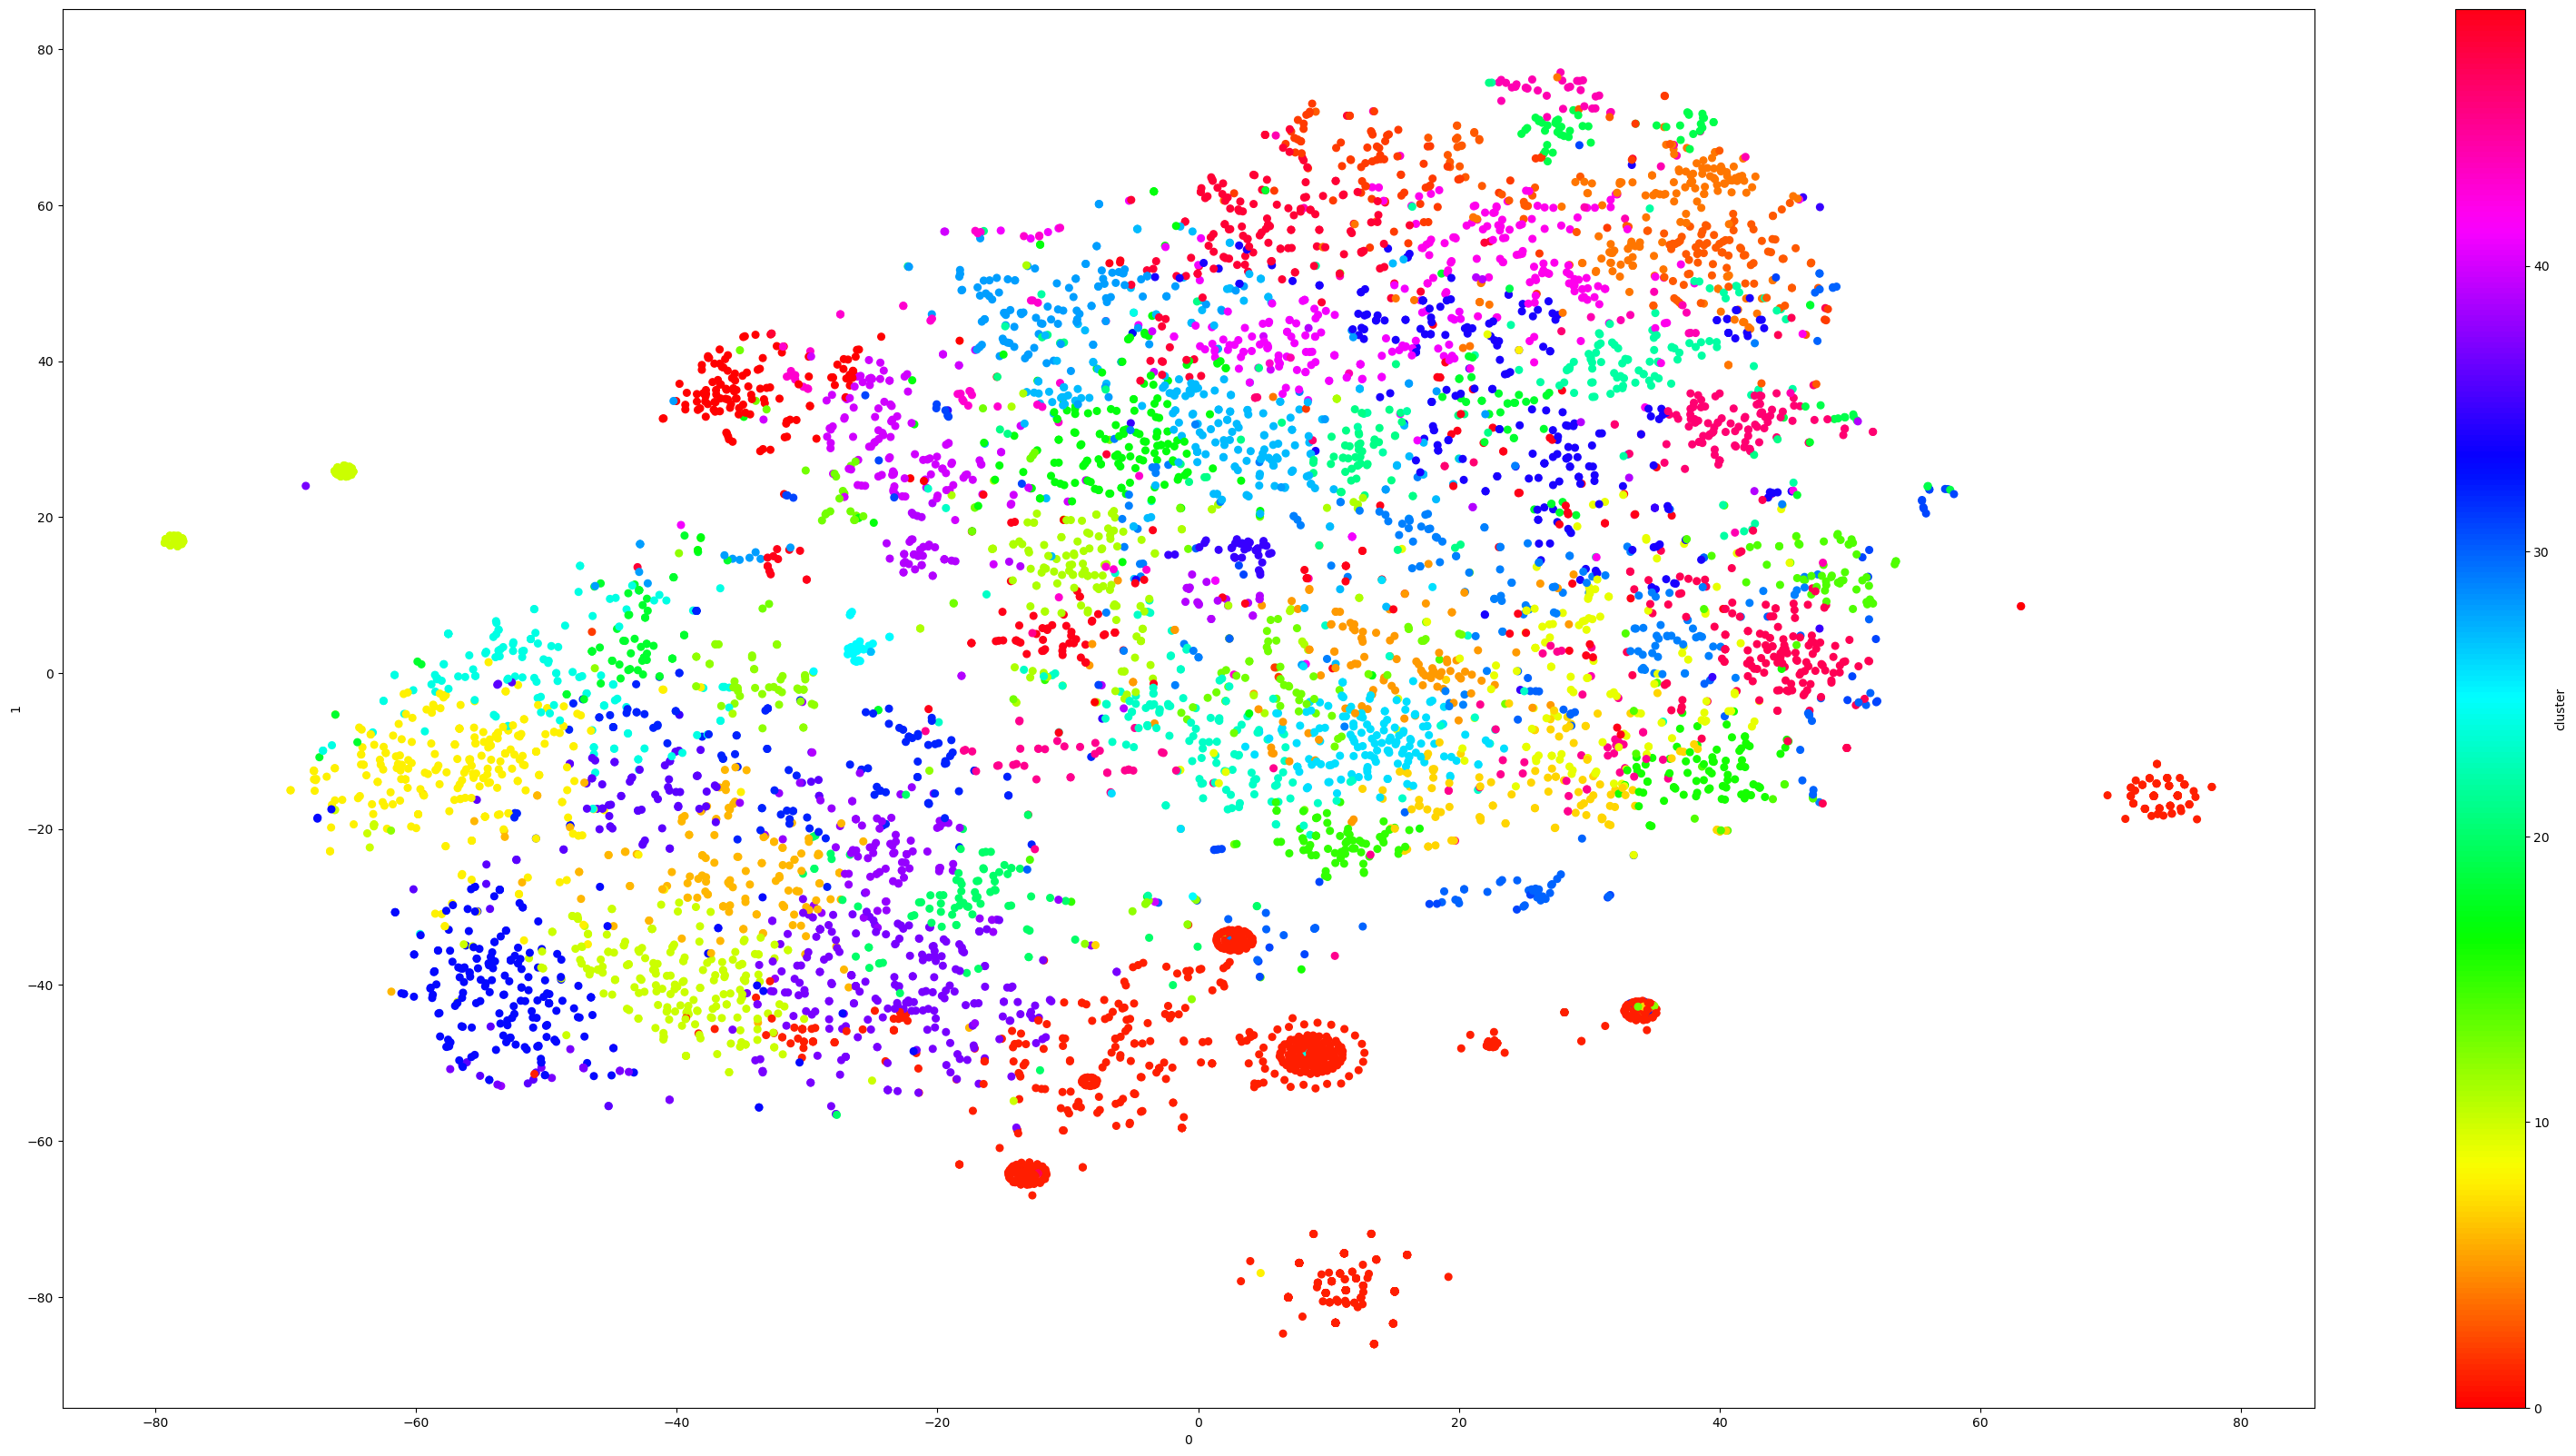

In [83]:
c_map_opt = ['Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']

#for cmap in c_map_opt:

pd.DataFrame(TSNE_2d).plot.scatter(x=0,y=1,c='cluster', cmap='hsv', s=30,figsize=(40,20))
plt.show()
plt.close()